In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset 
from torchvision import datasets, transforms as T
from torchvision.transforms import functional as TF
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import PIL

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:

def lbl_encode(lbl):
    off = [0, 5, 9, 12, 14]
    ids = np.nonzero(lbl)[0]
    vals = [lbl[i] for i in ids]
    new_lbl = 135 * [0]
    img_class = 15 * (vals[0] - 1) + off[ids[0]] + ids[1] - ids[0] - 1
    new_lbl[img_class] = 1

    return new_lbl

In [3]:
# transformers
def permute(input, permutation):
    return [input[i] for i in permutation]

def flatten(lst):
    return [item for sublst in lst for item in sublst] 
label_id = [range(10), range(10,20), range(20,30), range(30,40), range(40,50), range(50,60)]

class MyRandomRotation(object):
    def __init__(self):
        self.permutations = [
            [0, 1, 2, 3, 4, 5],
            [0, 1, 5, 4, 2, 3],
            [0, 1, 3, 2, 5, 4],
            [0, 1, 4, 5, 3, 2],
        ]

    def __call__(self, sample):
        image, label = sample
        rot = random.randint(0, 3)
        image = TF.rotate(image, rot * 90)
        # label: [squares, circles, up, down, left, right]
        label = torch.tensor(permute(label, self.permutations[rot]))
        return (image, label)


class MyRandomFlip(object):
    def __init__(self):
        self.permutations = [
            [0, 1, 2, 3, 4, 5],
            [0, 1, 2, 3, 5, 4],
        ]

    def __call__(self, sample):
        image, label = sample
        flip = random.randint(0, 1)
        if flip == 1:
            image = TF.hflip(image)
        # label: [squares, circles, up, down, left, right]
        label = torch.tensor(permute(label, self.permutations[flip]))
        return (image, label)

In [4]:
loader = T.Compose([
    T.ToTensor()])
transform = T.Compose([
    MyRandomRotation(),
    MyRandomFlip()
])

# transform = None

class CountingDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = None):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        filename = self.df.loc[index, 'name']

        squares = self.df.loc[index, "squares"]
        circles = self.df.loc[index, "circles"]
        up = self.df.loc[index, "up"]
        down = self.df.loc[index, "down"]
        right = self.df.loc[index, "right"]
        left = self.df.loc[index, "left"]

        label = torch.tensor([squares, circles, up, down, left, right])

        image = PIL.Image.open(os.path.join(self.images_folder, filename))

        if self.transform is not None:
            image, label = self.transform((image, label))
        
        label = torch.tensor(lbl_encode(label.numpy()))

        image = loader(image)[0].unsqueeze(0)

        return image.to(device, torch.float), label


In [5]:
image_size = 28
images_folder = './data'
csv_path = './data/labels.csv'

dataset_size = 10000
dev_dataset_size = 1000
val_dataset_size = 1000
train_dataset_size = dataset_size - dev_dataset_size - val_dataset_size

dataset = CountingDataset(csv_path, images_folder, transform)
train_dataset = Subset(dataset, range(train_dataset_size))
dev_dataset = Subset(dataset, range(train_dataset_size, train_dataset_size + dev_dataset_size))
val_dataset = Subset(dataset, range(train_dataset_size + dev_dataset_size, dataset_size))

tensor([[79]])
-----------------


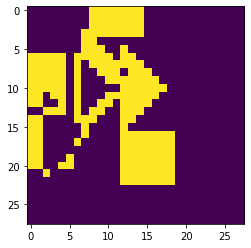

In [6]:
i = 1
d = val_dataset[i]
print(d[1].nonzero())
print('-----------------')
plt.imshow(d[0].cpu().numpy().reshape((28, 28)))
# label: [squares, circles, up, down, left, right]

In [7]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1),
            nn.BatchNorm2d(32),
            nn.SiLU()
            )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.SiLU(),
            )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2),
            nn.BatchNorm2d(128),
            nn.SiLU(),
        )

        self.drop_out_con = nn.Dropout(0.1)
        self.drop_out_fc = nn.Dropout(0.65)

        self.fc1 = nn.Sequential(
            nn.Linear(5 * 5 * 128, 128),
            nn.BatchNorm1d(128),
            nn.SiLU())
       
        self.fc2 = nn.Sequential(
            nn.Linear(128, 135))
    def forward(self, x):
        x = self.layer1(x)
        x = self.drop_out_con(x)
        x = self.layer2(x)
        x = self.drop_out_con(x)
        x = self.layer3(x)

        x = x.view(x.size(0), -1)

        x = self.drop_out_fc(x)
        x = self.fc1(x)
        x = self.drop_out_fc(x)
        x = self.fc2(x)
        x = x.softmax(dim=1)
        return x

In [8]:
batch_size = 16

params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 0}

train_generator = DataLoader(train_dataset, **params)
dev_generator = DataLoader(dev_dataset, **params)
val_generator = DataLoader(val_dataset, **params)

In [9]:
learning_rate = 0.01
weight_decay = 0

model = ConvNet()

optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8, dampening=0, weight_decay=weight_decay, nesterov=True)
criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    model = model.cuda()

# print(model)

In [10]:
def correct_num(predicted, target):

    maxPred = predicted.argmax(dim=1)
    maxTarg = target.argmax(dim=1)
    return (maxPred == maxTarg).sum()

In [12]:
round_num = 6
def train(max_epochs):

    dev_losses = []
    dev_accs = []
    train_losses = []
    train_accs = []

    for epoch in range(max_epochs):
        # Training
        train_loss = 0
        train_correct = 0
        model.train()
        for local_batch, local_labels in train_generator:
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            batch_size = local_batch.size()[0]

            optimizer.zero_grad()

            predicted_labels = model(local_batch)
            
            train_correct = train_correct + correct_num(predicted_labels, local_labels)

            loss = criterion(predicted_labels, local_labels.argmax(dim=1))
            
            loss.backward()
            optimizer.step()
            train_loss = train_loss + batch_size * loss 

        train_acc = train_correct / train_dataset_size
        train_loss = train_loss / train_dataset_size
        train_losses.append(train_loss.item())
        train_accs.append(train_acc.item())

        # Validation
        dev_loss = 0
        dev_correct = 0
        model.eval()
        with torch.set_grad_enabled(False):
            for local_batch, local_labels in dev_generator:
                local_batch, local_labels = local_batch.to(device), local_labels.to(device)
                batch_size = local_batch.size()[0]

                predicted_labels = model(local_batch)

                dev_correct = dev_correct + correct_num(predicted_labels, local_labels) 
                dev_loss = dev_loss + batch_size * criterion(predicted_labels, local_labels.argmax(dim=1))

        dev_acc = dev_correct / dev_dataset_size
        dev_loss = dev_loss / dev_dataset_size
        dev_losses.append(dev_loss.item())
        dev_accs.append(dev_acc.item())
        print('Epoch : ',epoch+1, '\t',
            'train_loss :', round(train_loss.item(), round_num),
            'train_acc:', round(train_acc.item(), round_num),
            'dev_loss :', round(dev_loss.item(), round_num),
            'dev_acc:', round(dev_acc.item(), round_num))
    return dev_losses, dev_accs, train_losses, train_accs


In [13]:
max_epochs = 250
print('TRAINING STARTED')
dev_losses, dev_accs, train_losses, train_accs = train(max_epochs)

77383 dev_acc: 0.145
Epoch :  30 	 train_loss : 4.79744 train_acc: 0.126125 dev_loss : 4.751431 dev_acc: 0.178
Epoch :  31 	 train_loss : 4.79946 train_acc: 0.122 dev_loss : 4.754758 dev_acc: 0.167
Epoch :  32 	 train_loss : 4.796212 train_acc: 0.12725 dev_loss : 4.759624 dev_acc: 0.171
Epoch :  33 	 train_loss : 4.786588 train_acc: 0.137625 dev_loss : 4.750377 dev_acc: 0.173
Epoch :  34 	 train_loss : 4.789865 train_acc: 0.13275 dev_loss : 4.754786 dev_acc: 0.174
Epoch :  35 	 train_loss : 4.781934 train_acc: 0.1395 dev_loss : 4.750624 dev_acc: 0.17
Epoch :  36 	 train_loss : 4.792299 train_acc: 0.13 dev_loss : 4.743179 dev_acc: 0.181
Epoch :  37 	 train_loss : 4.779287 train_acc: 0.143875 dev_loss : 4.738441 dev_acc: 0.191
Epoch :  38 	 train_loss : 4.781281 train_acc: 0.141875 dev_loss : 4.744562 dev_acc: 0.178
Epoch :  39 	 train_loss : 4.781309 train_acc: 0.141375 dev_loss : 4.74916 dev_acc: 0.173
Epoch :  40 	 train_loss : 4.77629 train_acc: 0.14625 dev_loss : 4.744475 dev_acc: 0

In [14]:
# validation
val_correct = 0
val_loss = 0
model.eval()
with torch.set_grad_enabled(False):
    for local_batch, local_labels in val_generator:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        batch_size = local_batch.size()[0]
        # Model computations
        predicted_labels = model(local_batch).to(torch.float32)
        
        val_correct = val_correct + correct_num(predicted_labels, local_labels) 

        val_loss = val_loss + batch_size * criterion(predicted_labels, local_labels.argmax(dim=1))
val_acc = val_correct / val_dataset_size
val_loss = val_loss / val_dataset_size

print('validation loss: ', val_loss.item(), 'validation accuracy: ', val_acc.item())


validation loss:  4.6814188957214355 validation accuracy:  0.23800000548362732


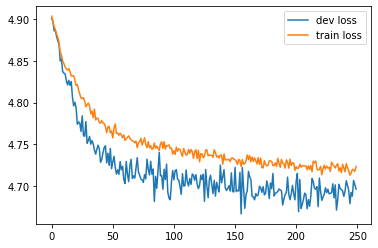

In [15]:
plt.plot(dev_losses)
plt.plot(train_losses)
plt.legend(['dev loss', 'train loss'])
plt.show()

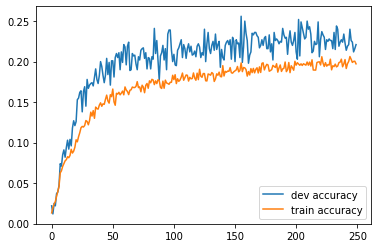

In [16]:
plt.plot(dev_accs)
plt.plot(train_accs)
plt.legend(['dev accuracy', 'train accuracy'])
plt.show()

<ipython-input-17-44b4000aa0a1>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


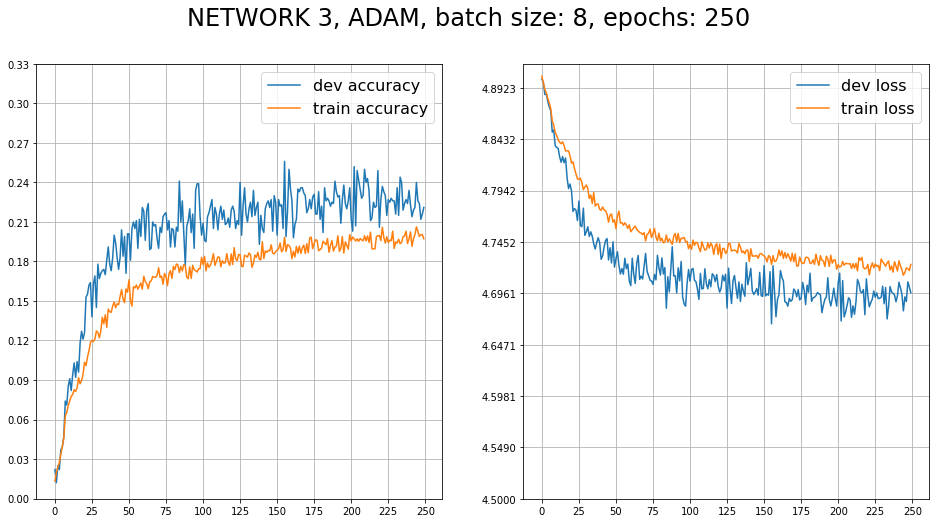

In [17]:
max_loss = max(max(dev_losses), max(train_losses))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle(f'NETWORK 3, ADAM, batch size: {batch_size}, epochs: {max_epochs}', fontsize=24)
ax1.plot(dev_accs)
ax1.plot(train_accs)
ax1.legend(['dev accuracy', 'train accuracy'], fontsize=16)
ax1.set_xticks(np.arange(0, max_epochs + 1, max_epochs/10))
ax1.set_yticks(np.arange(0, 0.33, 0.03))
ax1.grid()

ax2.plot(dev_losses)
ax2.plot(train_losses)
ax2.legend(['dev loss', 'train loss'], fontsize=16)
ax2.set_xticks(np.arange(0, max_epochs + 1, max_epochs/10))
ax2.set_yticks(np.arange(4.5, max_loss + 0.01, max_loss/100))
ax2.grid()

fig.show()